In [1]:
# Sql Alchemy Script
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from textwrap import wrap

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Reflect the Database into ORM class
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create inspector and connect to engine 
inspector = inspect(engine)

In [10]:
# Get column and data type from measurements table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Get column and data type from measurements table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

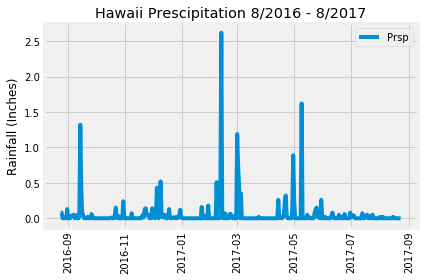

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date = list(np.ravel(max_date))[0]
        
max_date = dt.datetime.strptime(max_date, '%Y-%m-%d')
#print(max_date)

before_date = max_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

lst_year_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= before_date).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
#print(lst_year_prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column
# dropped dates with NAN values
lyp_df = pd.DataFrame(lst_year_prcp).dropna()
lyp_df['date'] = pd.to_datetime(lyp_df['date'])
#print(lyp_df)

# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(lyp_df['date'], lyp_df['prcp'])
plt.title("Hawaii Prescipitation 8/2016 - 8/2017", horizontalalignment='center')
plt.ylabel('Rainfall (Inches)')
plt.legend(["Prsp"])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Output/Prescipitation.png')
plt.show()

# Export file as a CSV, without the Pandas index, but with the header
lyp_df.to_csv("Output/Prescipitation_data.csv", index=True, header=True)

In [15]:
#  Use Pandas to calcualte the summary statistics for the precipitation data
# Print to output file
lyp_df.describe()
lyp_df.to_csv("Output/Summary_stats.csv", index=True, header=True)

In [16]:
# Design a query to show how many stations are available in this dataset?
query = session.query(func.count(Station.station)).all()
count = query[0][0]
print(f'There are {count} stations in the dataset')

There are 9 stations in the dataset


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
act_stations = [Measurement.station,
               func.count(Measurement.station)]
# List the stations and the counts in descending order.
act_stat_qry = session.query(*act_stations).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
act_stat_qry

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
low_temp = engine.execute('SELECT MIN(tobs) from measurement where station = "USC00519281"').fetchall()
low = low_temp[0][0]
round(low)
print(f'The lowest tempature at station USC00519281 was {low}')
high_temp = engine.execute('SELECT MAX(tobs) from measurement where station = "USC00519281"').fetchall()
high = high_temp[0][0]
round(high)
print(f'The highest tempature at station USC00519281 was {high}')
avg_temp = engine.execute('SELECT AVG(tobs) from measurement where station = "USC00519281"').fetchall()
avg = avg_temp[0][0]
avg = round(avg)
print(f'The average tempature at station USC00519281 was {avg}')

The lowest tempature at station USC00519281 was 54.0
The highest tempature at station USC00519281 was 85.0
The average tempature at station USC00519281 was 72


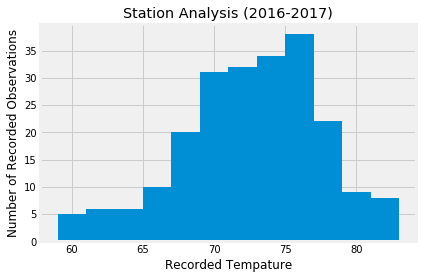

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = engine.execute('SELECT date, tobs from measurement where station = "USC00519281" and date > "2016-8-23"').fetchall()
temp_12_mnths = pd.DataFrame(temp_obs, columns = ["date", "tobs"])
temp_12_mnths.set_index('date', inplace = True)

#print(stat_9281)
plt.hist(temp_12_mnths['tobs'], 12)
plt.xlabel("Recorded Tempature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (2016-2017)")

# save figure
plt.savefig("Output/weather_analysis.png")
plt.show()